In [46]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")


In [47]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/home/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [48]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [49]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten(x, y, return_trend=False):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    if return_trend:
        return y / np.polyval(p, x), np.polyval(p, x)
    return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)
    
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu

In [116]:
def get_spectrum(spec):
    spec_data = pf.getdata(spec)
    wav = spec_data[3,:,:]
    flux = spec_data[0,:,:]# / spec_data[2,:,:]
    
    all_wav, all_flux = [], []
    for w, f in zip(wav[8:], flux[8:]):
        ivars = np.ones_like(w)
        mu = fit_continuum(w, f, ivars)
        f /= mu
        all_wav.extend(w)
        all_flux.extend(f)

    all_wav, all_flux = np.array(all_wav), np.array(all_flux)
    all_flux /= np.median(all_flux)
    all_flux = smooth(all_wav, all_flux, factor=0.1)
    return all_wav, all_flux

In [117]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
all_rv, all_rv_err = [], []
spec = all_spectra_files[0]

for spec in all_spectra_files:
    wav, flux = get_spectrum(spec)
    np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav / 10, flux, np.ones_like(flux) * 0.01)))
    star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    rv, rv_err = determine_radial_velocity_with_mask(star_spectrum)
    all_rv.append(rv)
    all_rv_err.append(rv_err)

[2020-10-08 02:52:48,460] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2020-10-08 02:52:48,480] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2020-10-08 02:52:48,501] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2020-10-08 02:52:48,529] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2020-10-08 02:52:48,558] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2020-10-08 02:52:48,609] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2020-10-08 02:52:48,641] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2020-10-08 02:52:48,663] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2020-10-08 02:52:48,683] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 90.77%
[2020-10-08 02:52:48,731] [INFO] [lines:__model_velocity_profile:2455]: Pe

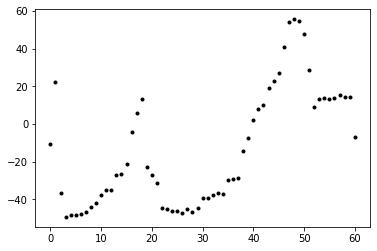

In [118]:
plt.plot(all_rv, '.k')

In [119]:
len(all_rv)

61

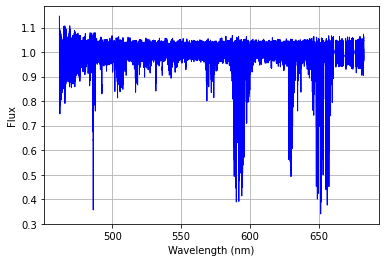

In [83]:
ispec.plotting.plot_spectra([star_spectrum])

In [110]:
def determine_radial_velocity_with_mask(star_spectrum):
    mu_cas_spectrum = star_spectrum
    #--- Radial Velocity determination with linelist mask --------------------------
    # - Read atomic data
#     mask_file = ispec_dir + "input/linelists/CCF/Narval.Sun.370_1048nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/Atlas.Arcturus.372_926nm/mask.lst""
    #mask_file = ispec_dir + "input/linelists/CCF/Atlas.Sun.372_926nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.A0.350_1095nm/mask.lst"
    mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.F0.360_698nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.G2.375_679nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.K0.378_679nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.K5.378_680nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/HARPS_SOPHIE.M5.400_687nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/Synthetic.Sun.350_1100nm/mask.lst"
    #mask_file = ispec_dir + "input/linelists/CCF/VALD.Sun.300_1100nm/mask.lst"
    ccf_mask = ispec.read_cross_correlation_mask(mask_file)

    models, ccf = ispec.cross_correlate_with_mask(mu_cas_spectrum, ccf_mask, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, mask_depth=0.01, \
                            fourier=False)

    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s
    return rv, rv_err

[2020-10-08 02:50:32,939] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2020-10-08 02:50:32,970] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2020-10-08 02:50:33,013] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2020-10-08 02:50:33,046] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2020-10-08 02:50:33,079] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2020-10-08 02:50:33,128] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2020-10-08 02:50:33,161] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2020-10-08 02:50:33,195] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2020-10-08 02:50:33,223] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 90.77%
[2020-10-08 02:50:33,279] [INFO] [lines:__model_velocity_profile:2455]: Pe

(-23.3, 2.7)

In [95]:
def clean_telluric_regions(star_spectrum):
    # - Telluric
    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)

    models, ccf = ispec.cross_correlate_with_mask(star_spectrum, telluric_linelist, \
                            lower_velocity_limit=-100, upper_velocity_limit=100, \
                            velocity_step=0.5, mask_depth=0.01, \
                            fourier = False,
                            only_one_peak = True)

    bv = np.round(models[0].mu(), 2) # km/s
    bv_err = np.round(models[0].emu(), 2) # km/s


    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)

    # - Filter regions that may be affected by telluric lines
    #bv = 0.0
    min_vel = -30.0
    max_vel = +30.0
    # Only the 25% of the deepest ones:
    dfilter = telluric_linelist['depth'] > np.percentile(telluric_linelist['depth'], 75)
    tfilter = ispec.create_filter_for_regions_affected_by_tellurics(star_spectrum['waveobs'], \
                                telluric_linelist[dfilter], min_velocity=-bv+min_vel, \
                                max_velocity=-bv+max_vel)
    clean_star_spectrum = star_spectrum[~tfilter]
    return clean_star_spectrum

In [96]:
cleaned = clean_telluric_regions(star_spectrum)

[2020-10-08 02:45:17,892] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2020-10-08 02:45:17,961] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2020-10-08 02:45:18,008] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2020-10-08 02:45:18,090] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2020-10-08 02:45:18,144] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2020-10-08 02:45:18,244] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2020-10-08 02:45:18,288] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2020-10-08 02:45:18,381] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2020-10-08 02:45:18,449] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 90.77%
[2020-10-08 02:45:18,514] [INFO] [lines:__model_velocity_profile:2455]: Pe

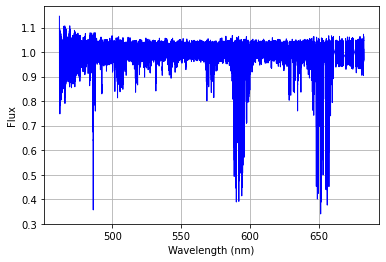

In [99]:
ispec.plotting.plot_spectra([cleaned])

In [53]:
def determine_radial_velocity_with_template():
    mu_cas_spectrum = ispec.read_spectrum(ispec_dir + "/input/spectra/examples/NARVAL_muCas.txt.gz")
    #--- Radial Velocity determination with template -------------------------------
    logging.info("Radial velocity determination with template...")
    # - Read synthetic template
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Arcturus.372_926nm/template.txt.gz")
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Sun.372_926nm/template.txt.gz")
    template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/NARVAL.Sun.370_1048nm/template.txt.gz")
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Synth.Sun.300_1100nm/template.txt.gz")

    models, ccf = ispec.cross_correlate_with_template(mu_cas_spectrum, template, \
                            lower_velocity_limit=-200, upper_velocity_limit=200, \
                            velocity_step=1.0, fourier=False)

    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s